<title>Lab 5 - Cross-Validation for Model Selection</title>

# Lab 5 - Cross-Validation for Model Selection
#### Parthasarathy Rajendiran <br>8883828<hr>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

#### Loading Diabetes dataset

In [2]:
diabetes_X, diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

X_train, X_test, y_train, y_test = train_test_split(diabetes_X, diabetes_y, test_size=0.2, random_state=8883828)

print(f'The dataset of size {diabetes_X.shape} has been splitted into')
print(f'Training   : {X_train.shape}')
print(f'Testing    : {X_test.shape}')

The dataset of size (442, 10) has been splitted into
Training   : (353, 10)
Testing    : (89, 10)


#### Cross validation of Polynomial models ranging from degree 0 to 8

In [3]:
results = []
for degree in range(9):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

    cv = KFold(n_splits=5, shuffle=True, random_state=8883828)

    # scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    # mae_scores = -scores

    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)

    mae_score = mean_absolute_error(y_train, y_train_pred)
    mape_score = mean_absolute_percentage_error(y_train, y_train_pred)
    r2 = r2_score(y_train, y_train_pred)

    results.append({'Degree': degree, f'R\u00b2': r2, 'MAE': mae_score, 'MAPE': mape_score})

#### Summarizing Cross validation results

In [4]:
results_df = pd.DataFrame(results)
display(results_df)

,Degree,R²,MAE,MAPE
0,0,-0.007779,65.936130,0.632679
1,1,0.491912,44.002901,0.400800
2,2,-0.294991,62.155391,0.538277
3,3,-13476.739302,1533.756033,12.090542
4,4,-105.880240,445.522376,3.765822
5,5,-805.289646,606.445208,5.472881
6,6,-1235.773873,742.616891,6.512530
7,7,-1304.434863,874.794276,7.273089
8,8,-1421.906398,1040.585687,7.909656


In [5]:
best_results = {}
for col in ['R²', 'MAE', 'MAPE']:
    best_score = results_df[col].max() if col == 'R²' else results_df[col].min()
    best_results[col] = {
        'Mean': results_df[col].mean(),
        'Std': results_df[col].std(),
        'Best Score': best_score,
        'Best Degree': results_df.loc[results_df[col] == best_score, 'Degree'].to_list()[0]
    }
best_results_df = pd.DataFrame(best_results).T
best_results_df['Best Degree'] = best_results_df['Best Degree'].astype(int)

##### Mean and Standard Deviation of metrics

In [6]:
display(best_results_df[['Mean', 'Std']])

,Mean,Std
R²,-2038.870576,4331.855416
MAE,601.757210,508.598374
MAPE,4.955142,4.000912


<h4>Finding best model</h4>based on the highest performance on each metric

Best Performance can be identified by finding the model with <br>
* the lowest Mean Absolute Error (MAE)
* the lowest Mean Absolute Percentage Error (MAPE)
* the R² closest to 1

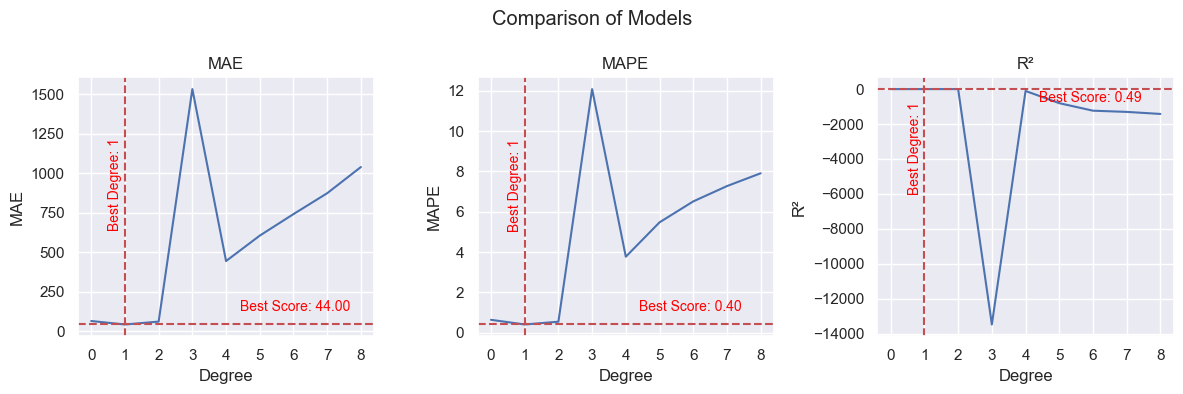

In [7]:
sns.set_theme()
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, metric in enumerate(['MAE', 'MAPE', 'R²']):
    sns.lineplot(results_df, x='Degree', y=metric, ax=axes[i])

    deg = best_results[metric]['Best Degree']
    scr = best_results[metric]['Best Score']
    sd = best_results[metric]['Std']
    x_center = (axes[i].get_xlim()[1] - axes[i].get_xlim()[0]) / 2
    y_center = (axes[i].get_ylim()[1] - axes[i].get_ylim()[0]) / 2
    y_off = (results_df[metric].max() - results_df[metric].min()) / len(results_df)
    y_dir = -1 if best_results[metric]['Mean'] < 0 else 1
    axes[i].axvline(x=deg, color='r', linestyle='--')
    axes[i].text(deg - 0.5, (y_center - y_off)*y_dir, f'Best Degree: {deg}', fontsize=10, color='red', rotation='vertical')
    axes[i].axhline(y=scr, color='r', linestyle='--')
    axes[i].text(x_center, (scr + (y_off/2))*y_dir, f'Best Score: {scr:.2f}', fontsize=10, color='red', rotation='horizontal')
    axes[i].set_title(metric)
    axes[i].xaxis.set_ticks(results_df['Degree'])

plt.suptitle('Comparison of Models')
fig.tight_layout()
plt.show()

In [8]:
best_degree = best_results_df['Best Degree'].mode().to_list()[0]
best_degree
display(best_results_df[['Best Score', 'Best Degree']])

print(f'\n\n Based on the above details and graph,\n the best model is with the Polynomial degree of {best_degree}')

,Best Score,Best Degree
R²,0.491912,1
MAE,44.002901,1
MAPE,0.400800,1




 Based on the above details and graph,
 the best model is with the Polynomial degree of 1


<br>  

#### Analyzing the performance of the best model with test data

In [9]:
best_model = make_pipeline(PolynomialFeatures(degree=best_degree), LinearRegression())
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

best_model_metrics = pd.DataFrame([
    {
        f'R\u00b2': r2_score(y_test, y_pred), 
        'MAE': mean_absolute_error(y_test, y_pred), 
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    }
], index=['Best Model'])

display(best_model_metrics)

,R²,MAE,MAPE
Best Model,0.481523,44.322581,0.34949


The metrics with test data is similar to the metrics of cross validation best model with train data. <br>
So this model gives consistent result without bias or variance.

---